In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

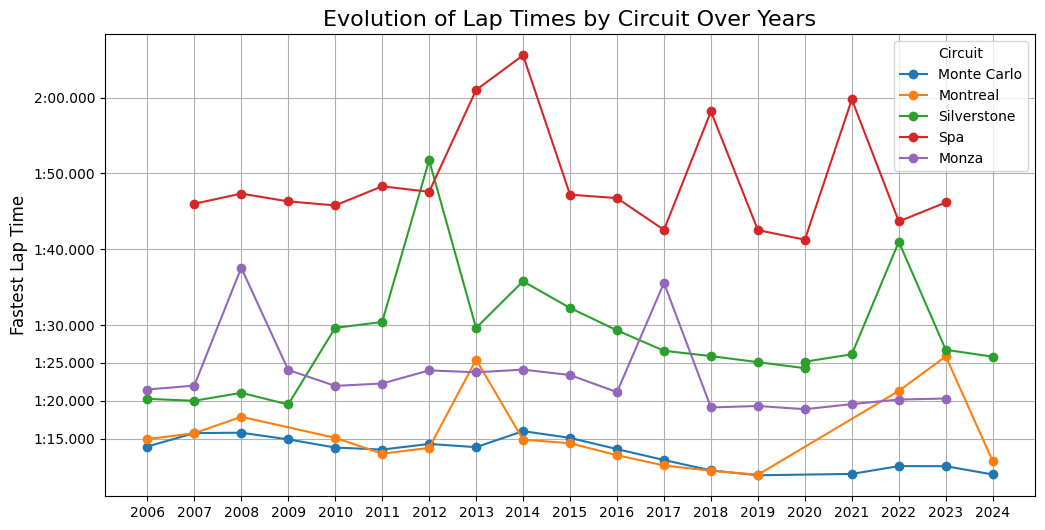

In [82]:
races_list = ['Monte-Carlo', 'Montreal', 'Silverstone', 'Spa', 'Monza']

circuits_df = pd.read_csv('datasets/circuits.csv')
circuits_mapping_df = circuits_df[circuits_df['location'].isin(races_list)][['circuitId', 'location']]


races_df = pd.read_csv('datasets/races.csv')
circuits_races_df = races_df[races_df['circuitId'].isin(circuits_mapping_df['circuitId'])][['raceId', 'year', 'circuitId']]
circuits_races_df = pd.merge(circuits_races_df, circuits_mapping_df, on='circuitId')


qualifying_df = pd.read_csv('datasets/qualifying.csv')
qualifying_races_df = qualifying_df[qualifying_df['raceId'].isin(circuits_races_df['raceId'])][['raceId', 'q3']]
qualifying_races_df = qualifying_races_df[qualifying_races_df['q3'] != r'\N']

circuits_races_df = pd.merge(circuits_races_df, qualifying_races_df, on='raceId')



idx = circuits_races_df.groupby('raceId')['q3'].idxmin()
circuits_races_df = circuits_races_df.loc[idx]
circuits_races_df.sort_values(by='year', inplace=True)


pole_times_df = circuits_races_df.drop(columns=['raceId'])
pole_times_df['q3'] = pd.to_timedelta('00:' + pole_times_df['q3']).dt.total_seconds()


plt.figure(figsize=(12, 6))
for circuit_id, group in pole_times_df.groupby('circuitId'):
    plt.plot(
        group['year'], 
        group['q3'], 
        marker='o', 
        label=f'Circuit {circuit_id}'
    )

yticks_seconds = [75, 80, 85, 90, 100, 110, 120] 
yticks_labels = ['1:15.000', '1:20.000', '1:25.000', '1:30.000', '1:40.000', '1:50.000', '2:00.000']
plt.yticks(yticks_seconds, yticks_labels)

xticks_years = sorted(pole_times_df['year'].unique()) 
plt.xticks(xticks_years)

plt.title('Evolution of Lap Times by Circuit Over Years', fontsize=16)
plt.ylabel('Fastest Lap Time', fontsize=12)
plt.legend([
    'Monte Carlo', 'Montreal', 'Silverstone', 'Spa', 'Monza'
    ],title='Circuit', fontsize=10)
plt.grid(True)
plt.show()

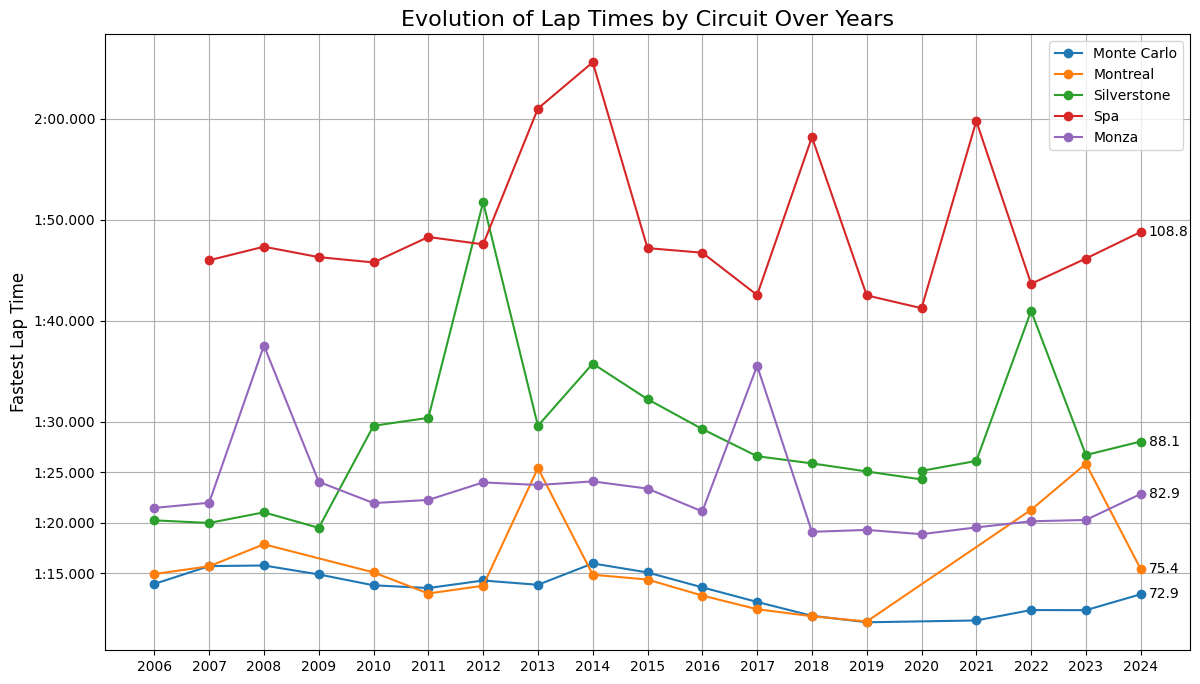

In [126]:
regression_df = pole_times_df.copy().drop(columns=['circuitId'])
regression_df = regression_df[regression_df['year'] != 2024]
regression_df = pd.get_dummies(regression_df, columns=['location'], drop_first=False)

regression_df


X = regression_df[['year', 'location_Monte-Carlo', 'location_Montreal', 'location_Monza', 'location_Silverstone', 'location_Spa']]
y = regression_df['q3']

model = LinearRegression()
model.fit(X, y)

next_year = 2024
next_data = {
    'year': [next_year, next_year, next_year, next_year, next_year],
    'location_Monte-Carlo': [1, 0, 0, 0, 0],
    'location_Montreal': [0, 1, 0, 0, 0],
    'location_Monza': [0, 0, 1, 0, 0],
    'location_Silverstone': [0, 0, 0, 1, 0],
    'location_Spa': [0, 0, 0, 0, 1],
    
}
next_df = pd.DataFrame(next_data)
predicted_q3 = model.predict(next_df)

pole_times_df = pole_times_df[pole_times_df['year'] != 2024]
next_data = {
    'year': [next_year] * 5,  # Same year for all locations
    'location': ['Monte-Carlo', 'Montreal', 'Monza', 'Silverstone', 'Spa'],  # Track locations,
    'circuitId': [6, 7, 14, 9, 13],
    'q3': predicted_q3  # Predicted q3 values for 2024
}

predictions_df = pd.DataFrame(next_data)

# Concatenate the original DataFrame with the predictions DataFrame
pole_times_df = pd.concat([pole_times_df, predictions_df], ignore_index=True)
pole_times_df

plt.figure(figsize=(14, 8))
for circuit_id, group in pole_times_df.groupby('circuitId'):
    line, =plt.plot(
        group['year'], 
        group['q3'], 
        marker='o', 
        label=f'Circuit {circuit_id}'
    )
    last_year = group['year'].iloc[-1]
    last_q3 = group['q3'].iloc[-1]
    plt.text(
        last_year + 0.15, 
        last_q3, 
        f'{last_q3:.1f}',  # Display q3 value
        fontsize=10,
        ha='left', 
        va='center'
    )

yticks_seconds = [75, 80, 85, 90, 100, 110, 120] 
yticks_labels = ['1:15.000', '1:20.000', '1:25.000', '1:30.000', '1:40.000', '1:50.000', '2:00.000']
plt.yticks(yticks_seconds, yticks_labels)

xticks_years = sorted(pole_times_df['year'].unique()) 
plt.xticks(xticks_years)

plt.title('Evolution of Lap Times by Circuit Over Years', fontsize=16)
plt.ylabel('Fastest Lap Time', fontsize=12)
plt.legend([
    'Monte Carlo', 'Montreal', 'Silverstone', 'Spa', 'Monza'
    ], fontsize=10)
plt.grid(True)
plt.show()
